<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/master/Complete_assignment_13%3A55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 17

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib


In [0]:
# General packages
import numpy as np 
import pandas as pd
import math

# Plotting figures
import matplotlib.pyplot as plt
import seaborn

# Preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import datasets as ds

# Featureselection
from sklearn import svm
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import decomposition

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter selection
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Evaluation and Learning curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
# Data loading functions. This script uses ADNI data.
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # Keep all data without column 'label'
Y = data['label']              # Associated 'label' of data
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # Convert AD and CN to 1 and 0
AD = (list(data['label'] == 0)).count(False)
print(f'The number of AD patients: {AD}')     # Displays number AD patients
CN = (list(data['label'] == 0)).count(True)
print(f'The number of CN patients: {CN}')     # Displays number of CN patients 
percentage_CN=CN/(AD+CN)                      # To determine threshold below
print(f'Percentage of CN patients: {percentage_CN}') # Displays percentage CN-patients

The number of samples: 855
The number of columns: 268
The number of AD patients: 519
The number of CN patients: 336
Percentage of CN patients: 0.3929824561403509


In [0]:
# Preprocessing(1/4). Drop feature if values are constant or too many values are missing, also replace zero by NaN.  
threshold_CN = percentage_CN/2 
X=X.loc[:,X.apply(pd.Series.nunique) != 1]    # If column shows same value for every sample, drop feature
X_constant = X                                # Data left after removing constant features

X= X.replace(0, np.NaN)                       # Replace 0 with NaN
X = X.replace(0.0,np.NaN)                     # Just to be sure, that every zero is replaced with NaN
missing_per_feature = X.isnull().sum()        # Gives the amount of missing values (NaN) per feature
pct_null = missing_per_feature / len(X)       # Gives percentage of missing values per feature
missing_features = pct_null[pct_null > threshold_CN].index    # Gives features with more than 20% missing values
X.drop(missing_features, axis=1, inplace=True)                # Removes feature if more than 20% of values is missing

print(f'Data after removing constant features: {X_constant.shape}')       
print(f'Data after removing features missing too many values: {X.shape}')  

Data after removing constant features: (855, 260)
Data after removing features missing too many values: (855, 258)


In [0]:
# Preprocessing(2/4). Split into train (70%) and test (30%) set.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

In [0]:
# Preprocessing(3/4). Impute missing values (fill missing values).

imputer = impute.SimpleImputer(strategy='mean')       # Imputer with mean 
imputer.fit(X_train)                                  # Fit the imputer to the train data
X_train_imp=imputer.transform(X_train)                # Transform the X_train data with the trained imputer
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns])  # Turn created np.array back to pandas df

X_test_imp = imputer.transform(X_test)                # Apply imputer to test data   
X_test_imp = pd.DataFrame(data=X_test_imp, index=[X_test.index], columns=[X_test.columns])      # Turn created np.array back to pandas df

In [0]:
# Preprocessing(4/4). Scaling using StandardScaler. 

scaler = preprocessing.StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)        # Scaling the training data
X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])  # Turn created np.array back to pandas df

X_test_scaled = scaler.transform(X_test_imp)          # Scaling the test data
X_test_scaled = pd.DataFrame(data=X_test_scaled, index=[X_test.index], columns=[X_test.columns])      # Turn created np.array back to pandas df

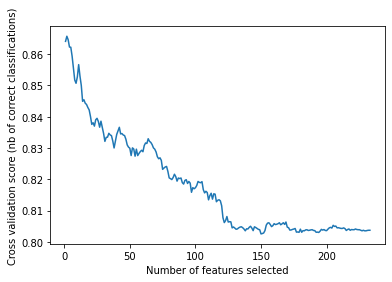

Location of the selected features: [  1   4   5   7   9  11  15  21  25  26  29  36  44  45  46 114 131 134
 143 144 161 163 173 182 186 215 220]


In [0]:
# Feature selection(1/6). First method of greedy feature slection through backward feature elimination.

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel='linear', random_state=0)

# Classifications
countfeatures =len(X_train_scaled.columns)
ten_percent = round(0.1*countfeatures)             # Minimal features to select needs to be at least ten percent of all features
rfecv = feature_selection.RFECV(estimator=svc,step=1,min_features_to_select=ten_percent, cv=model_selection.StratifiedKFold(5),scoring='roc_auc')
rfecv.fit(X_train_scaled,y_train)
X_train_best_array=rfecv.transform(X_train_scaled) # Apply RFECV on scaled training data

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("RFECV validation of best number of features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Print best features and df of selected features
bestfeatures = rfecv.get_support(True)              # Determine the best features
XX=X_train_scaled.iloc[:,bestfeatures]              # Df consisting of only the selected features
print(f'Location of the selected features: {bestfeatures}') 

In [0]:
# Feature selection(2/6). Code for validating first method of feature selection.
y=y_train
XX_length=len(XX)                          # To show selected best features
 
# Apply SelectKBest class to show the best features individually
best2 = SelectKBest(score_func= f_classif, k='all') # Using ANOVA test and k= number of bestfeatures
fit = best2.fit(XX,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(XX.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']         # Naming the dataframe columns
print(featureScores.nlargest(XX_length,'Score'))  # Print best features 

                                 Specs       Score
0                        (hf_entropy,)  423.684797
25                (tf_LBP_std_R3_P12,)  321.374737
5                            (hf_std,)  296.448361
17            (tf_Gabor_0.05A0.0skew,)  219.682332
4                          (hf_range,)  158.632554
26                (tf_NGTDM_Contrast,)  156.635504
18            (tf_Gabor_0.05A1.57max,)  133.371457
19           (tf_Gabor_0.05A1.57mean,)  108.926975
1                           (hf_mean,)   85.223747
3                           (hf_peak,)   84.009389
16             (tf_Gabor_0.05A0.0max,)   83.842663
15  (tf_GLSZM_GrayLevelNonUniformity,)   77.624052
24            (tf_Gabor_0.5A0.79mean,)   51.249746
2                         (hf_median,)   41.627816
23             (tf_Gabor_0.5A0.0skew,)   20.653797
6               (logf_entropy_sigma1,)    7.634710
11       (logf_quartile_range_sigma1,)    6.307691
12             (logf_skewness_sigma5,)    6.006746
20             (tf_Gabor_0.2A0.

Text(0.5, 1.0, 'Scatterplot of best individual features of rfecv selected features')

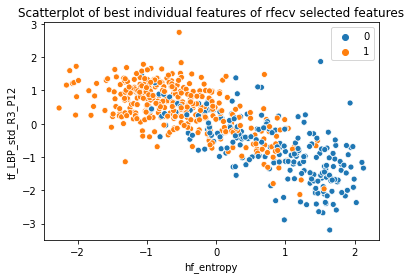

In [0]:
# Feature selection(3/6). Scatterplot of 2 best features according to SelectKbest after RFECV.
sorted_scores_df = featureScores.nlargest(2,'Score')    # select only best two
sorted_scores_df.reset_index(level=0, inplace=True,)    # reset index to be able to call original index
best1=sorted_scores_df.loc[0,'index']                   # call original index of best feature
best2=sorted_scores_df.loc[1,'index']                   # call original index of second best feature

x1=XX.iloc[:,best1]               # Extracting the best feature from dataset containing only rfecv selected features
x2=XX.iloc[:,best2]               # Extracting the second best feature from dataset containing only rfecv selected features 
y = np.array(y_train)

seaborn.scatterplot(x=x1, y=x2, hue=y)
plt.title('Scatterplot of best individual features of rfecv selected features')

[[-4.14336206e+00  2.60304549e+00 -2.10344265e+00 ... -2.88489168e-16
  -1.52901256e-16 -5.51927915e-16]
 [-2.81735255e+00  3.58259595e+00  3.26078190e+00 ... -5.46888673e-16
  -2.15608143e-17  1.07387623e-15]
 [ 1.76904398e+01  7.79535096e+00  5.42807558e+00 ...  2.57030896e-16
  -7.92088550e-16  1.45663040e-15]
 ...
 [ 6.60365129e+00  3.12102647e+00  8.87730892e-01 ... -1.55259430e-17
  -1.09032633e-16 -1.40321594e-16]
 [ 4.00520294e+00 -4.04301061e+00 -4.90346195e+00 ... -1.47994165e-16
   7.53299560e-17  6.14414867e-16]
 [-2.54733037e+00 -5.02985034e+00 -2.35999526e+00 ...  1.47198743e-16
  -9.68336259e-17 -9.97142736e-16]]


Text(0.5, 1.0, 'Scatterplot of two first PCs')

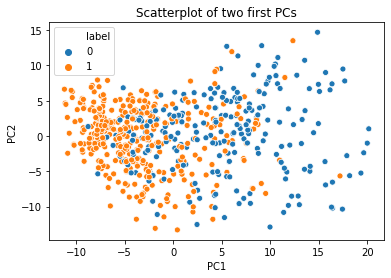

In [0]:
# Feature selection(4/6). Second method of feature selection using PCA, including scatterplot of two first PSc.
pca = decomposition.PCA(n_components=countfeatures) # First n_components is all features, fill in a more fitting number after performing the code below 
X_pca= X_train_scaled
pca.fit(X_pca)
pca.transform(X_pca)          # PCA on training data
y= y_train
print(X_train_pca)            # Values of the PCs

seaborn.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y) # Scatterplot of two first PCs
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of two first PCs')

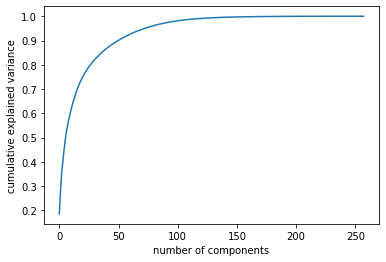

In [0]:
# Feature selection(5/6). Plot for validation of right number of components for PCA with explained variance ratio.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [0]:
# Feature selection(6/6). Applying chosen feature selection (RFECV) to the test dataset.
XX_test=rfecv.transform(X_test_scaled)            # Apply RFECV on scaled test data

In [0]:
# Classifiers(1/4). Random Forest Classifier.

# Set parameters for RF classifier
parameters = {"n_estimators": list(range(1, 20, 2))}

score = 'balanced_accuracy'
# Parameter optimization is done using (5fold) crossvalidation
print('# Random Forest Classifier')
rfc = RandomForestClassifier()
grid_search = GridSearchCV(
    rfc, parameters, scoring=score
) 
 
grid_search.fit(XX, y_train)

clf_rf = grid_search.best_estimator_
best_parameters_rf = grid_search.best_params_
print(f"Best parameter found on development set: {best_parameters_rf}")
score_rf = grid_search.best_score_
print(f"Grid score on development set: {score_rf}")

# Random Forest Classifier

Best parameter found on development set: {'n_estimators': 15}
Grid score on development set: 0.791924932802228


In [0]:
# Classifiers(2/4). Support Vector Machine Classifier.

# Set parameters for SVC
parameters = [{'kernel': ['rbf'], 'gamma': [2**-8, 2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-1, 2**0, 2**1, 2**2, 2**3],
                     'C': [2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3]},
              {'kernel':['linear'], 'C': [2**-3, 2**-1, 2**0, 2**1, 2**2, 2**3]}]

score='balanced_accuracy'
# Parameter optimization is done using (5fold) crossvalidation
print('# Support Vector Machine Classifier')
svc = SVC()
grid_search = GridSearchCV(
    svc, parameters, scoring=score
) 

grid_search.fit(XX, y_train)

clf_svm = grid_search.best_estimator_
best_parameters_svm = grid_search.best_params_
print(f"Best parameters set found on development set: {best_parameters_svm}")
score_svm = grid_search.best_score_
print(f"Grid score on development set: {score_svm}")

# Support Vector Machine Classifier
Best parameters set found on development set: {'C': 1, 'kernel': 'linear'}
Grid score on development set: 0.8445399786262507


In [0]:
# Classifiers(3/4). K Nearest Neighbour Classifier.

# Set parameters
parameters = {"n_neighbors": list(range(1, 50, 2))}

score = 'balanced_accuracy'
# Parameter optimization is done using (5fold) crossvalidation
print("# K Nearest Neighbour Classifier")
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn, parameters, scoring=score
) 

grid_search.fit(XX, y_train)

clf_knn = grid_search.best_estimator_
best_parameters_knn = grid_search.best_params_
print(f"Best parameter found on development set: {best_parameters_knn}")
score_knn = grid_search.best_score_
print(f"Grid score on development set: {score_knn}")

# K Nearest Neighbour Classifier
Best parameter found on development set: {'n_neighbors': 15}
Grid score on development set: 0.7828188250914861


In [0]:
# Classifiers(4/4). Code for choosing the best performing classifier, based on the balanced accuracies calculated above.

all_scores = {clf_rf : score_rf, clf_svm : score_svm, clf_knn : score_knn}

best_classifier=max(all_scores, key=all_scores.get)
print(f"Best classifier: {best_classifier}")


Best classifier: SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
# Evaluation(1/3). Applying the chosen best classifier on the test data.
print('# Evaluate with test data set')
y_true, y_pred = y_test, best_classifier.predict(XX_test)

auc=metrics.roc_auc_score(y_true, y_pred)
print(f'AUC:{auc}')
accuracy=metrics.balanced_accuracy_score(y_true, y_pred)
print(f'balanced accuracy:{accuracy}')
F1=metrics.f1_score(y_true,y_pred)
print(f'F1:{F1}')
precision=metrics.precision_score(y_true,y_pred)
print(f'precision:{precision}')
recall=metrics.recall_score(y_true, y_pred)
print(f'recall:{recall}')

# Evaluate with test data set
AUC:0.8051535922823051
balanced accuracy:0.8051535922823052
F1:0.8615384615384615
precision:0.8284023668639053
recall:0.8974358974358975


In [0]:
# Evaluation(2/3). Function for learning curve.
# Retrieved from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

<Figure size 1728x576 with 0 Axes>

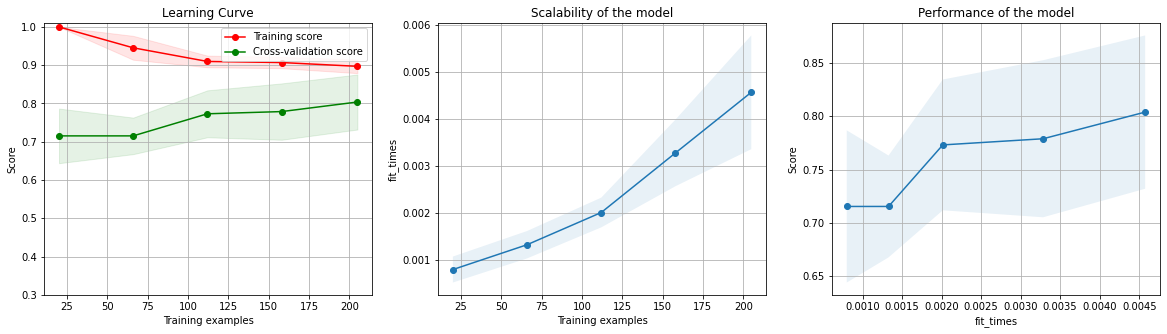

In [0]:
# Evaluation(3/3). Code for creating Learning Curve of our test data.

X = XX_test
Y = y_test

# Create a cross-validation object
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)   

# Make figure
title = 'Learning Curve'
fig = plt.figure(figsize=(24,8))
plot_learning_curve(best_classifier, title, X, Y, ylim=(0.3, 1.01), cv=cv)